Bootstrapping can lead to a potentially better estimation for data parameters or model coefficients, 
because the bootstrapped mean, or other statistics, will usually converge to the true value faster than 
the parameters/coefficients found using standard statistical estimation.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

### Bootstraping data from a uniform dist

'Mean is 0.45022804942273653'

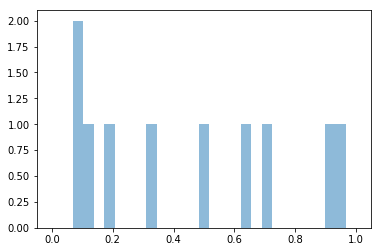

In [2]:
bins = np.linspace(0, 1, 30)
data = np.random.uniform(0, 1, size=10)
plt.hist(data, bins=bins, alpha=0.5)
f"Mean is {data.mean()}"

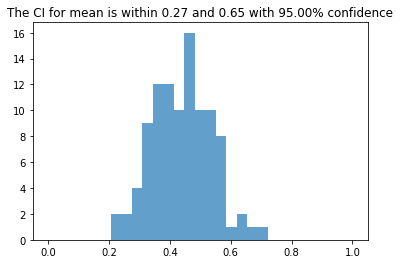

In [3]:
def bootstrap(data, statistic=np.mean, ci_width=0.95, num_bootstrap=100):
    data = np.asarray(data)
    num_samples = len(data)
    bootstrapped_ary = []
    for i in range(num_bootstrap):
        idx = np.random.randint(num_samples, size=num_samples)
        bootstrapped_ary.append( statistic(data[idx]) )
    bootstrapped_ary.sort()
    ci_min = (1-ci_width)/2
    ci_max = (1-ci_min)
    ci_min_val = bootstrapped_ary[int(ci_min*num_bootstrap)]
    ci_max_val = bootstrapped_ary[int(ci_max*num_bootstrap)]
    return bootstrapped_ary, ci_min_val, ci_max_val

ci_width = .95
bootstrapped_mean, ci_min_val, ci_max_val = bootstrap(data, ci_width=ci_width)
plt.hist(bootstrapped_mean, bins=bins, alpha=0.7)
plt.title(f"The CI for mean is within {ci_min_val:.2} and {ci_max_val:.2} with {ci_width:.2%} confidence");

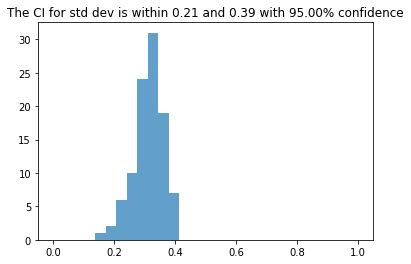

In [4]:
def unbiased_std(x):
    return np.std(x, ddof=1)

bootstrapped_std, ci_min_val, ci_max_val = bootstrap(data, statistic=unbiased_std)
plt.hist(bootstrapped_std, bins=bins, alpha=0.7)
plt.title(f"The CI for std dev is within {ci_min_val:.2} and {ci_max_val:.2} with {ci_width:.2%} confidence");

### Bootstrapinog bimodal dist

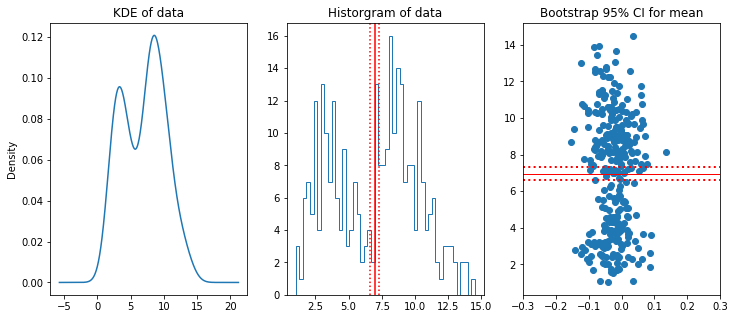

In [5]:
def bootstrap2(data, statistic, alpha, num_samples):
    data_len = len(data)
    idx = np.random.randint(data_len, size=(num_samples, data_len))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return stat[int((alpha/2.0)*num_samples)], stat[int(0.5*num_samples)], stat[int((1-alpha/2.0)*num_samples)]

# prep bimodal data
x = np.concatenate([np.random.normal(3, 1, 100), np.random.normal(9, 2, 200)])

# select statistic
statistic = np.mean

# find mean 95% CI and 100,000 bootstrap samples
# low, median, high = bootstrap2(x, 100000, np.std, 0.05)
computed_low, computed_median, computed_high = bootstrap2(x, statistic, 0.05, 100000)

# make plots
plt.figure(figsize=(12,5))
plt.subplot(131)
pd.Series(x).plot.kde();
plt.title('KDE of data')
plt.subplot(132)
plt.hist(x, 50, histtype='step')
plt.axvline(computed_low, c='r', linestyle=':')
plt.axvline(computed_median, c='r')
plt.axvline(computed_high, c='r', linestyle=':')
plt.title('Historgram of data')
plt.subplot(133)
plt.plot([-0.3,0.3], [statistic(x), statistic(x)], 'r', linewidth=1)
plt.scatter(0.05*(np.random.randn(len(x))-0.5), x)
plt.plot([-0.3,0.3], [computed_low, computed_low], 'r:', linewidth=2)
plt.plot([-0.3,0.3], [computed_high, computed_high], 'r:', linewidth=2)
plt.xlim([-0.3, 0.3])
plt.title('Bootstrap 95% CI for mean');

### Bootstraping model coef

In [6]:
from sklearn.datasets import load_boston
boston = load_boston()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

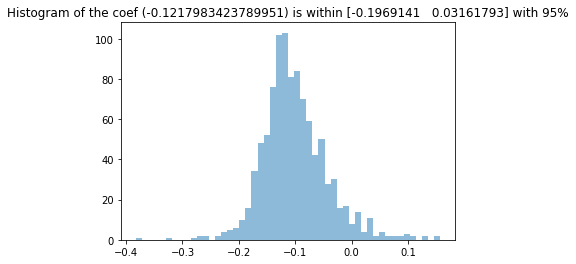

In [7]:
num_bootstraps = 1000
len_boston = len(boston.target)
subsample_size = np.int(0.5*len_boston)
subsample = lambda: np.random.choice(np.arange(0, len_boston), size=subsample_size)
coef_ary = np.ones(num_bootstraps) # pre-allocate storage for the coefs

for i in range(num_bootstraps):
    subsample_idx = subsample()
    subsample_X = boston.data[subsample_idx]
    subsample_y = boston.target[subsample_idx]
    lr.fit(subsample_X, subsample_y)
    coef_ary[i] = lr.coef_[0]
    
f = plt.figure()
ax = f.add_subplot(111)
ax.hist(coef_ary, bins=50, alpha=.5)
ax.set_title(f"Histogram of the coef ({lr.coef_[0]}) is within {np.percentile(coef_ary, [2.5, 97.5])} with 95%");

### Permutaion resampling

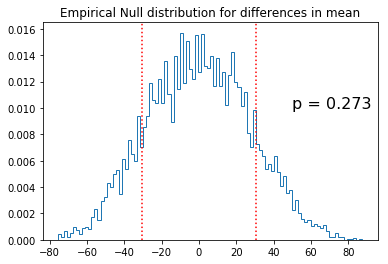

In [8]:
def permutation_resampling(sample, control, num_permutaions, statistic):
    observed_diff = abs(statistic(sample) - statistic(control))
    num_sample = len(sample)
    combined = np.concatenate([sample, control])
    diff_ary = []
    for i in range(num_permutaions):
        xs = np.random.permutation(combined)
        # diff = np.mean(xs[:num_sample]) - np.mean(xs[num_sample:])
        diff = statistic(xs[:num_sample]) - statistic(xs[num_sample:])
        diff_ary.append(diff)
    pval = (np.sum(observed_diff<diff_ary) + np.sum(diff_ary<-observed_diff))/num_permutaions
    return pval, observed_diff, diff_ary


# make up some data
sample = [94, 38, 23, 197, 99, 16, 141]
control = [52, 10, 40, 104, 51, 27, 146, 30, 46]

# find p-value by permutation resampling
pval, observed_diff, diff_ary = permutation_resampling(sample, control, 10000, np.mean)

# make plots
plt.title('Empirical Null distribution for differences in mean')
plt.hist(diff_ary, bins=100, histtype='step', density=True)
plt.axvline(observed_diff, c='r', ls=':')
plt.axvline(-observed_diff, c='r', ls=':')
plt.text(50, 0.01, 'p = %.3f' % pval, fontsize=16);

### THE END